# Text Classification Assessment

This assessment is a text classification project where the goal is to classify the genre of a movie based on its characteristics, primarily the text of the plot summarization. You have a training set of data that you will use to identify and create your best predicting model. Then you will use that model to predict the classes of the test set of data. We will compare the performance of your predictions to your classmates using the F1 Score. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

The **movie_train.csv** dataset contains information (`Release Year`, `Title`, `Plot`, `Director`, `Cast`) about 10,682 movies and the label of `Genre`. There are 9 different genres in this data set, so this is a multiclass problem. You are expected to primarily use the plot column, but can use the additional columns as you see fit.

After you have identified yoru best performing model, you will create predictions for the test set of data. The test set of data, contains 3,561 movies with all of their information except the `Genre`. 

Below is a list of tasks that you will definitely want to complete for this challenge, but this list is not exhaustive. It does not include any tasds around handling class imbalance or about how to test multiple different models and their tuning parameters, but you should still look at doing those to see if they help you to create a better predictive model.


# Good Luck

In [ ]:
# data cleaning and plotting libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

In [2]:
#nltk libraries

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

In [4]:
# kera libraries

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation

Using TensorFlow backend.


In [6]:
#plotly libraries

In [7]:
from chart_studio.plotly import iplot
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [8]:
# sklearn libraries

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer #tfidf
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier #bagging and randomforest
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm #svm

### Task #1: Perform imports and load the dataset into a pandas DataFrame


In [10]:
import pandas as pd
train = pd.read_csv('movie_train.csv')

In [215]:
test = pd.read_csv('movie_test.csv',index_col=0)

In [216]:
test.head()

,Release Year,Title,Plot,Director,Cast
5075,1950,Chain Gang,After a state senator's bill to abolish chain ...,Lew Landers,"Douglas Kennedy, Marjorie Lord"
32149,2003,Aithe,Irfan Khan (Pavan Malhotra) is a key mafia aff...,Chandrashekar Yeleti,"Sashank, Sindhu Tolani, Abhishek, Mohit"
7154,1958,Wild Heritage,The film tells the story of Emma Breslin (O'Su...,Charles Haas,"Will Rogers, Jr., Maureen O'Sullivan"
4259,1946,In Fast Company,The boys are involved in an altercation with a...,Del Lord,"The Bowery Boys, Jane Randolph"
7548,1961,"Stop, Look and Laugh",Paul Winchell plays a father to Jerry Mahoney ...,"Don Appell, Louis Brandt","Three Stooges, Paul Winchell"


### Task #2: Check for missing values:

In [12]:
# Check for NaN values:
train.isnull().sum().sum()

169

In [13]:
# Check for whitespace strings (it's OK if there aren't any!):
import string
def contains_whitespace(s):
    return True in [c in s for c in string.whitespace]
contains_whitespace(train['Plot'])

False

### Task #3: Remove NaN values:

In [14]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    return text

In [15]:
train['cleanplot'] = train['Plot'].apply(lambda x: clean_text(x))

In [16]:
def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()


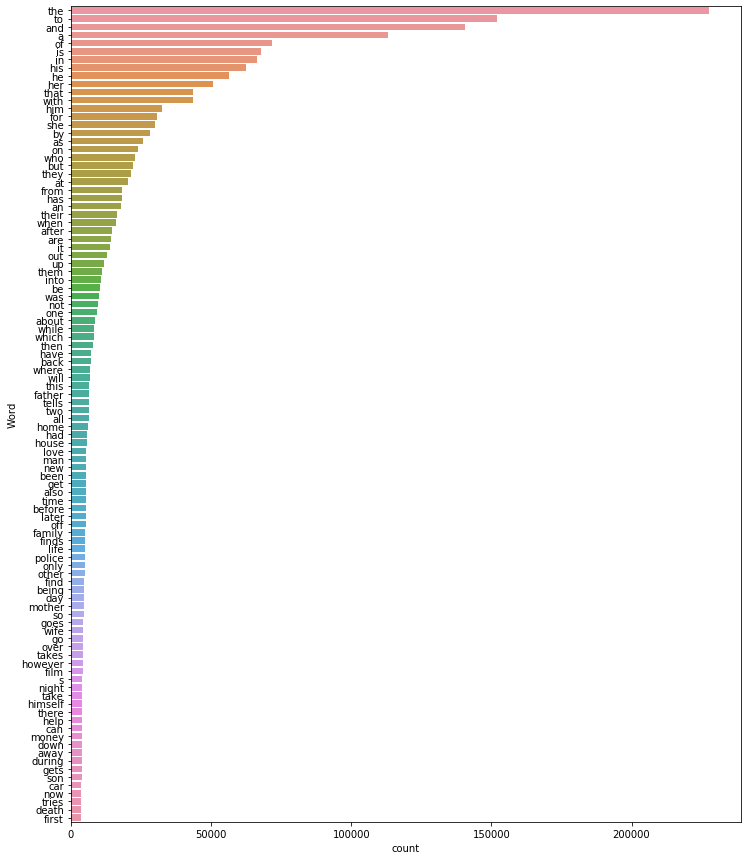

In [17]:
### print 100 most frequent words 
freq_words(train['cleanplot'], 100)

## Remove STOPWORDS

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/zoe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [172]:
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

stop_words.extend(["one","back"])
# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

train['cleanplot'] = train['cleanplot'].apply(lambda x: remove_stopwords(x))

In [46]:
#freq_words(train['cleanplot'], 100)

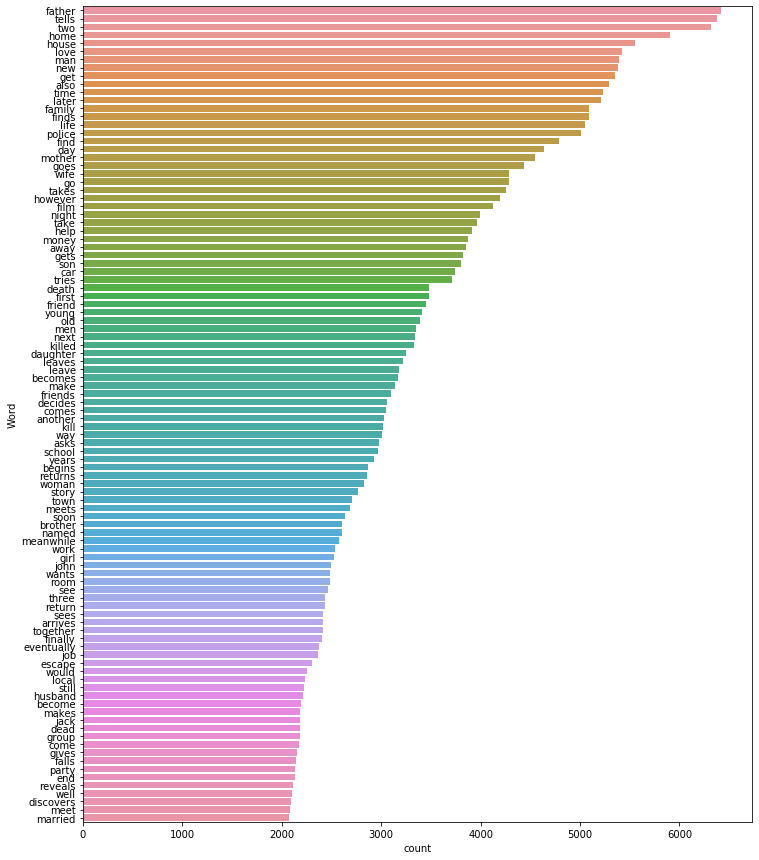

In [173]:
freq_words(train['cleanplot'], 100)

## Functions to compare models

In [21]:
def evaluate(test, pred, model):
    return [model, 
            precision_score(test, pred, average = 'weighted'), 
            recall_score(test, pred,average = 'weighted'), 
            accuracy_score(test, pred), 
            f1_score(test, pred, average = 'weighted')]

In [22]:
def print_accuracy_indices(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds, average = 'weighted')))
    print("Recall Score: {}".format(recall_score(labels, preds, average = 'weighted')))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds, average = 'weighted')))

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf.fit(train['cleanplot'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [85]:
train['Director1'] = train['Director'].str.replace('[^\w\s]','')

In [205]:
train['new'] = train.cleanplot + ' '+ train.Director1 +' '+ train.Title +' '+ train.Title 

In [206]:
X = tfidf.transform(train['new'])
y, label = pd.factorize(train['Genre'])


In [207]:
from imblearn.over_sampling import ADASYN 
sm = ADASYN()
X, y = sm.fit_sample(X, y)

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [209]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import time

In [210]:
start = time.time()
svclassifier = LinearSVC(C = 40)
svclassifier.fit(X_train, y_train)
svc_runtime = time.time() - start

/Users/zoe/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



LinearSVC(C=40, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [211]:
preds = svclassifier.predict(X_test)

In [212]:
print_accuracy_indices(y_test, preds)

Precision Score: 0.9320281186488425
Recall Score: 0.9358411494711635
Accuracy Score: 0.9358411494711635
F1 Score: 0.932449615575804


In [112]:
test['cleanplot'] = test['Plot'].apply(clean_text)

In [114]:
test['Director1'] = test['Director'].str.replace('[^\w\s]','')

In [115]:
test['new'] = test.cleanplot + ' ' + test.Director +' '+ test.Title +' '+ test. Title

In [116]:
xtestplot = tfidf.transform(test['new'])

In [155]:
pred = svclassifier.predict(xtestplot)

In [213]:
pred

array([1, 4, 3, ..., 7, 1, 1])

In [121]:
pred_label = label[pred]

In [219]:
preds_csv = pd.DataFrame(pred_label, index = test.index).to_csv('predictions1.csv', header = False)

# RidgeClassifier

In [200]:
from sklearn.linear_model import RidgeClassifier


In [201]:
rcl = RidgeClassifier(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, 
                                        tol=0.001, class_weight=None, solver='auto', random_state=42)

In [202]:
rcl = rcl.fit(X_train,y_train)

In [203]:
rcl.predict(X_test)

array([5, 2, 0, ..., 0, 3, 2])

In [204]:
print_accuracy_indices(y_test, rcl.predict(X_test))

Precision Score: 0.9186930303938163
Recall Score: 0.923974857826998
Accuracy Score: 0.923974857826998
F1 Score: 0.9188086404480773


## RANDOM FOREST

In [135]:
start = time.time()
rfclassifier = RandomForestClassifier(n_estimators=100)
rfclassifier.fit(X_train, y_train)
rf_runtime = time.time() - start

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [137]:
rf_pred = rfclassifier.predict(X_test)  

In [138]:
print_accuracy_indices(y_test, rf_pred)

Precision Score: 0.9071705782633905
Recall Score: 0.8963487629688747
Accuracy Score: 0.8963487629688747
F1 Score: 0.8928620739512027


In [ ]:
## naive Bayes


In [227]:

# training a Naive Bayes classifier 
from sklearn.naive_bayes import GaussianNB 
start = time.time()
gnb = GaussianNB().fit(X.todense(), y.todense()) 
gnb_predictions = gnb.predict(x_test) 
# accuracy on X_test 
accuracy = gnb.score(x_test, y_test) 
nb_runtime = time.time() - start

print (accuracy) 
# creating a confusion matrix 
nbcm = confusion_matrix(y_test, gnb_predictions)

AttributeError: 'numpy.ndarray' object has no attribute 'todense'

# Multinomial Naives Bayes

In [221]:
start = time.time()
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
mnb_runtime = time.time() - start
mnb_runtime

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

0.13603687286376953

In [224]:
mnbpred = mnb.predict(X_test)

In [225]:
print_accuracy_indices(y_test, mnbpred)

Precision Score: 0.828910020910595
Recall Score: 0.823987228098184
Accuracy Score: 0.823987228098184
F1 Score: 0.7990995710195224


### Task #4: Take a look at the columns and do some EDA to familiarize yourself with the data. 

### Task #5: Split the data into train & test sets:

Yes we have a holdout set of the data, but you do not know the genres of that data, so you can't use it to evaluate your models. Therefore you must create your own training and test sets to evaluate your models. 

### **transform target variables


In [140]:

print(pd.crosstab(y_test, rf_pred, rownames=['Actual'], colnames=['Predicted']))

Predicted     0    1     2     3    4     5     6     7     8
Actual                                                       
0          1143   46     0     0    3     0     0     1     0
1            24  899    26    13   71    58    18     8     7
2             1   44  1029     1    3     4     1     0     3
3             0   10     0  1120    0     0     0     0     0
4            25  454    17    10  407    39    14     5     9
5             0   41     1     0    2  1014     0     0     0
6             1   57     2     0    5     1  1089     0     0
7             0    4     0     0    0     0     0  1115     0
8             0   10     0     0    0     0     0     0  1169


### Task #6: Build a pipeline to vectorize the date, then train and fit your models.
You should train multiple types of models and try different combinations of the tuning parameters for each model to obtain the best one. You can use the SKlearn functions of GridSearchCV and Pipeline to help automate this process.


### Task #7: Run predictions and analyze the results on the test set to identify the best model.  

In [ ]:
# Form a prediction set


In [ ]:
# Report the confusion matrix



In [ ]:
# Print a classification report


In [ ]:
# Print the overall accuracy and F1 score


### Task #8: Refit the model to all of your data and then use that model to predict the holdout set. 

### #9: Save your predictions as a csv file that you will send to the instructional staff for evaluation. 

## Great job!